In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
from time import sleep
from IPython.display import clear_output
%matplotlib inline
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
import pandas as pd

In [2]:
class MyEnv(gym.Env):
    def __init__(self, n=8):
        assert n % 4 == 0, "n must be a multiple of 4 for symmetry"
        self.n = n
        self.angles = np.linspace(0, 2*np.pi, n, endpoint=False)  # Equally spaced angles
        self.action_vectors = np.column_stack((np.cos(self.angles), np.sin(self.angles)))
        
        self.action_space = spaces.Discrete(n)
        self.observation_space = spaces.Box(low=np.array([-2.0, -2.0]), high=np.array([2.0, 2.0]))
        self.state = np.array([0.0, 0.0])
        self.step_size = 0.2
        self.env_shape = "SQUARE"
        self.trajectory = [self.state.copy()]

    def reset(self, init=False, point=np.array([0,0])):
        if not init:
            self.state = np.random.rand(2) * 4 - 2  # Anywhere in [-2,2]
        else:
            self.state = point
        self.trajectory = [self.state.copy()]
        return self.state

    def step(self, action):
        x, y = self.state
        delta_action = self.action_vectors[action] * self.step_size
        x_new = x + delta_action[0]
        y_new = y + delta_action[1]
        
        # Reflect at boundaries
        if x_new < -2:
            x_new = -4 - x_new  # Reflect from -2 boundary
        elif x_new > 2:
            x_new = 4 - x_new  # Reflect from 2 boundary
        
        if y_new < -2:
            y_new = -4 - y_new  # Reflect from -2 boundary
        elif y_new > 2:
            y_new = 4 - y_new  # Reflect from 2 boundary
        
        self.state = np.array([x_new, y_new])
        reward = 0
        done = False
        
        if self.env_shape == "SQUARE":
            if -1.0 <= x_new <= 1.0 and -1.0 <= y_new <= 1.0:
                reward += 1.0
            elif -2.0 < x_new < 2.0 and -2.0 < y_new < 2.0:
                reward -= 1.0
            else:
                reward -= 2.0
        
        self.trajectory.append(self.state.copy())
        return self.state, reward, done, {}

    def render(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,6))
        x_coords = [point[0] for point in self.trajectory]
        y_coords = [point[1] for point in self.trajectory]
        
        square_2 = patches.Rectangle((-2, -2), 4, 4, linewidth=1, edgecolor='k', linestyle='--', facecolor='gray', alpha=0.7)
        ax.add_patch(square_2)
        square = patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor='k', linestyle='--', facecolor='gold', alpha=0.7, label='Reward region')
        ax.add_patch(square)
        
        ax.plot(x_coords, y_coords, label='Trajectory')
        ax.scatter(x_coords[-1], y_coords[-1], color='red', label='Agent')
        ax.scatter(x_coords[0], y_coords[0], color='black', label='Initial Point')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_title("Environment")
        ax.set_xlabel("X axis")
        ax.set_ylabel("Y axis")
        ax.legend()

c:\Users\g\anaconda3\envs\torch\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


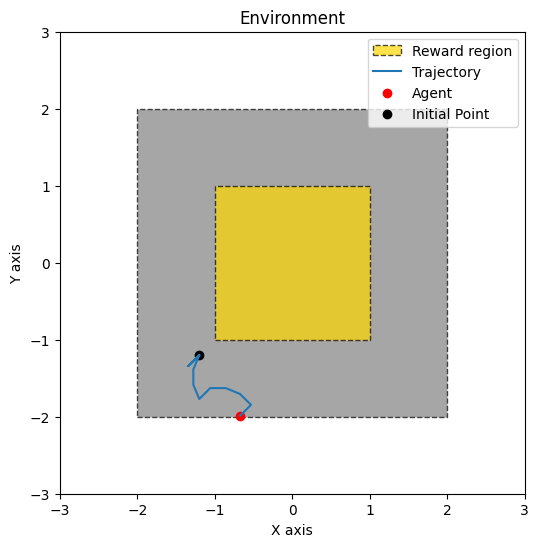

In [3]:
env = MyEnv(n=16)
state = env.reset(init=True, point=np.array([-1.2, -1.2]))
total_reward = 0
for i in range(10):
    # clear_output(wait=True)
    action = env.action_space.sample()  # Random direction
    state, reward, done, _ = env.step(action)
    if done:
        break
    # env.render()
    # plt.show()
    # sleep(0.001)
    # total_reward += reward
    # print("Reward : ", total_reward)
env.render()
plt.show()

In [24]:
class Shared_model(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(Shared_model, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.action_dim = action_dim
        self.actor = nn.Linear(hidden_size, action_dim)  # Mean of the action distribution
        self.value = nn.Linear(hidden_size, 1)  # Output a single value representing state value
        self.beta_sigmoid = 10
        self.init_weights()
        
    def init_weights(self):
        # Xavier Initialization for fc1 and fc2
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.actor.weight)
        nn.init.xavier_uniform_(self.value.weight)

        # Set biases for positive value output
        nn.init.constant_(self.fc1.bias, 0.1)
        nn.init.constant_(self.fc2.bias, 0.1)
        nn.init.constant_(self.actor.bias, 0.0)  
        nn.init.constant_(self.value.bias, 1.0)
    
    def forward(self, state, threshold=0):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        val = self.value(x)
        action_d1 = self.actor(x)
        action_d2 = torch.rand(self.action_dim)
        sigmoid_ = 1 / (1 + torch.exp(-self.beta_sigmoid * (val - threshold)))
        action = F.softmax((1-sigmoid_) * action_d1 + sigmoid_ * action_d2, dim=-1)
        return action, val

In [32]:
def actor_critic_bg(model_shared, episodes, max_steps=100, gamma=0.99, lr_shared=1e-5, n=8):
    optimizer_shared = optim.Adam(model_shared.parameters(), lr=lr_shared)
    stats = {'Total Loss': [], 'Returns': [], 'a_loss':[], 'c_loss':[]}
    env = MyEnv(n)
    for episode in range(1, episodes + 1):
        state = env.reset()
        ep_return = 0
        done = False
        step_count = 0
        if episode<1000:
            threshold = -5
        elif episode>=1000 and episode<2000:
            threshold = -1
        elif episode>=2000:
            threshold = 0
        while not done and step_count < max_steps:
            state_tensor = torch.FloatTensor(state)
            action_probs, val = model_shared(state_tensor, threshold)
            action_prob, action = torch.max(action_probs, dim=0)       
            next_state, reward, done, _ = env.step(action)
            next_value = model_shared(torch.FloatTensor(next_state), threshold)[1]
            td_target = reward + gamma * next_value * (1 - done)
            advantage = td_target - val
            critic_loss = F.mse_loss(val, td_target.detach())
            log_prob = torch.log(action_prob)
            actor_loss = -log_prob * advantage.detach()
            total_loss = actor_loss + critic_loss
            optimizer_shared.zero_grad()
            total_loss.backward()
            optimizer_shared.step()
            state = next_state
            ep_return += reward
            step_count += 1
        stats['Total Loss'].append(total_loss.item())
        stats['a_loss'].append(actor_loss.item())
        stats['c_loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return)
        print(f"Episode {episode}: Total Loss: {total_loss.item():.4f}, Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}, Return: {ep_return}, Steps: {step_count}")
    return stats

In [33]:
input_size = env.observation_space.shape[0]
num_actions = 16
model_shared = Shared_model(input_size, num_actions, hidden_size=64)
num_episodes = 10000
stats = actor_critic_bg(model_shared, num_episodes, lr_shared=1e-5, max_steps=100, gamma=0, n=num_actions)

Episode 1: Total Loss: -0.8500, Actor Loss: -4.3211, Critic Loss: 3.4711, Return: 10.0, Steps: 100
Episode 2: Total Loss: 0.1070, Actor Loss: 0.1051, Critic Loss: 0.0019, Return: -36.0, Steps: 100
Episode 3: Total Loss: -0.3492, Actor Loss: -0.3736, Critic Loss: 0.0245, Return: 64.0, Steps: 100
Episode 4: Total Loss: -0.9429, Actor Loss: -4.4732, Critic Loss: 3.5303, Return: -16.0, Steps: 100
Episode 5: Total Loss: 0.4422, Actor Loss: 0.4131, Critic Loss: 0.0291, Return: 4.0, Steps: 100
Episode 6: Total Loss: -0.4237, Actor Loss: -5.2096, Critic Loss: 4.7858, Return: -48.0, Steps: 100
Episode 7: Total Loss: -1.1273, Actor Loss: -4.2113, Critic Loss: 3.0840, Return: -96.0, Steps: 100
Episode 8: Total Loss: 1.2761, Actor Loss: 1.0804, Critic Loss: 0.1957, Return: -78.0, Steps: 100
Episode 9: Total Loss: -1.4234, Actor Loss: -3.6358, Critic Loss: 2.2124, Return: 6.0, Steps: 100
Episode 10: Total Loss: 0.7565, Actor Loss: 0.6759, Critic Loss: 0.0806, Return: -62.0, Steps: 100
Episode 11: T

In [25]:
model_shared = Shared_model(2,16,64)
model_shared.load_state_dict(torch.load('true_bg_square.pth'))

C:\Users\g\AppData\Local\Temp\ipykernel_25456\2923716370.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_shared.load_state_dict(torch.load('true_bg_square.pth'))


<All keys matched successfully>

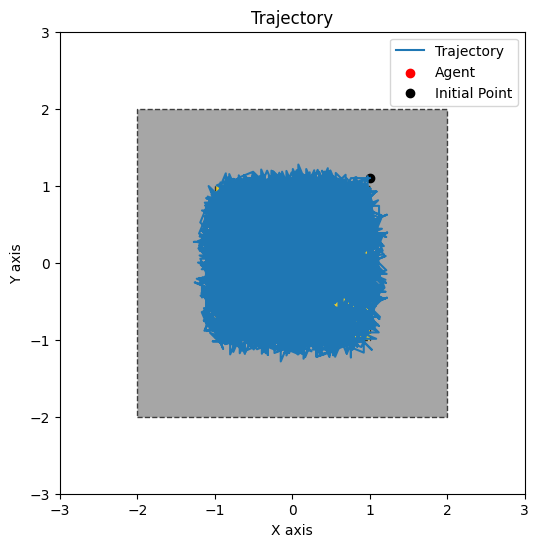

Total reward in human mode: 7578.0


In [ ]:
env = MyEnv(16)
state = env.reset(init = True, point = np.array([-1.8, -1.8]))
done = False
total_reward = 0
max_steps = 10000
steps = 0
thresh = 0.0


while not done and steps < max_steps:
    if steps % 1000 ==0:
        clear_output(wait=True)
        env.render()
        plt.show()
        sleep(0.01)
    state_tensor = torch.FloatTensor(state)
    action_probs, val = model_shared(state_tensor, thresh)
    action_prob, action = torch.max(action_probs, dim=0)            
    state, reward, done, _ = env.step(action)
    total_reward += reward
    if steps >= max_steps:
        break
    steps+=1
print(f"Total reward in human mode: {total_reward}")

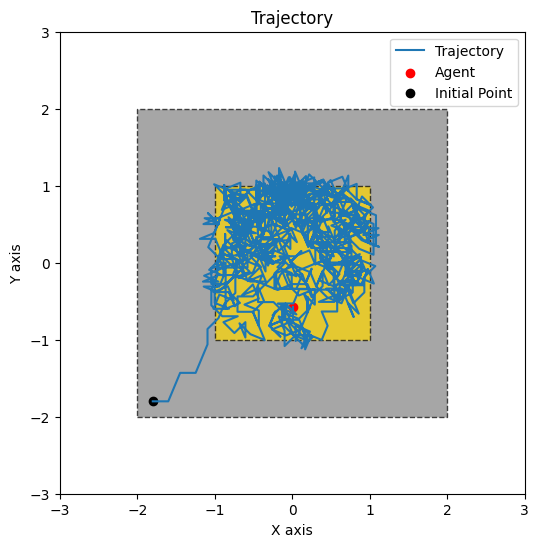

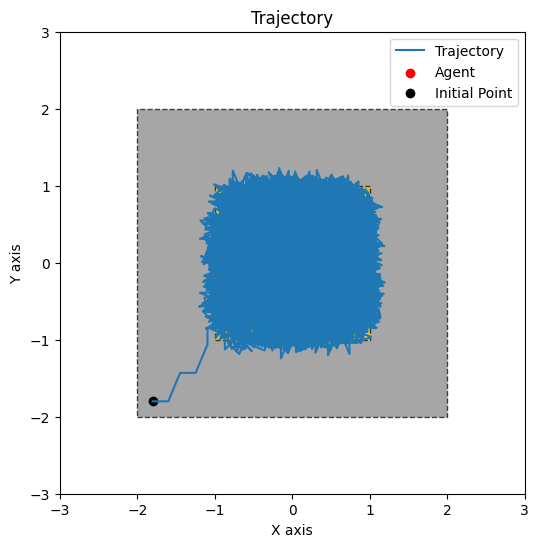

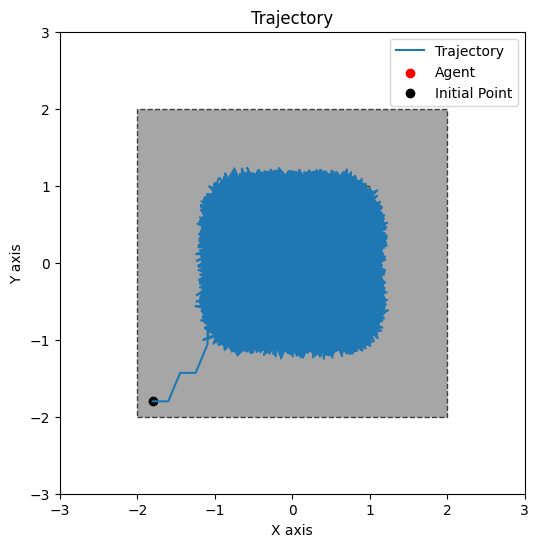

In [31]:
env = MyEnv(n=16)
state = env.reset(init=True, point=np.array([-1.8,-1.8]))
done = False
total_reward = 0
max_steps = 100000
steps = 1
thresh = 0.1

while not done and steps < max_steps:
    state_tensor = torch.FloatTensor(state)
    action_probs, val = model_shared(state_tensor, thresh)
    action_prob, action = torch.max(action_probs, dim=0)            
    state, reward, done, _ = env.step(action)
    total_reward += reward
    if steps >= max_steps:
        break
    steps+=1
    if steps==1000 or steps==10000:
        env.render()
        plt.show()
env.render()

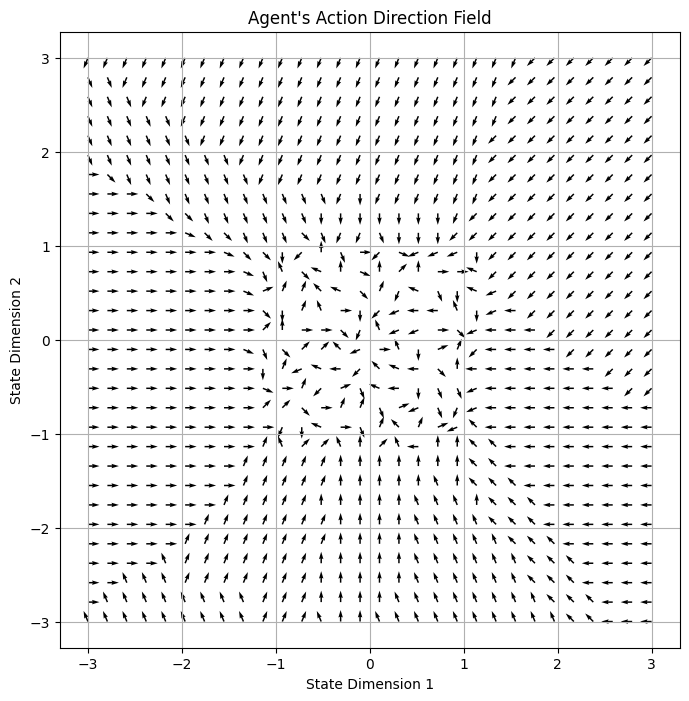

In [32]:
num_actions = 16
angles = np.linspace(0, 2 * np.pi, num_actions, endpoint=False)
action_vectors = np.stack((np.cos(angles), np.sin(angles)), axis=1)

# 2. Create a grid over the 2D space (e.g., from -1 to 1)
grid_size = 30
x = np.linspace(-3, 3, grid_size)
y = np.linspace(-3, 3, grid_size)
X, Y = np.meshgrid(x, y)

# 3. Compute the agent's action at each point
U = np.zeros_like(X)  # x-component of vector
V = np.zeros_like(Y)  # y-component of vector

for i in range(grid_size):
    for j in range(grid_size):
        state = np.array([X[i, j], Y[i, j]])  # Modify if your state is higher-dimensional
        action_probs, val = model_shared(torch.FloatTensor(state),threshold=0)
        action_prob, action = torch.max(action_probs, dim=0)
        action_idx = action.item()
        direction = action_vectors[action_idx]
        U[i, j] = direction[0]
        V[i, j] = direction[1]

# 4. Plot using quiver
plt.figure(figsize=(8,8))
plt.quiver(X, Y, U, V, angles='xy')
plt.title("Agent's Action Direction Field")
plt.xlabel("State Dimension 1")
plt.ylabel("State Dimension 2")
plt.axis('equal')
plt.grid(True)
plt.show()


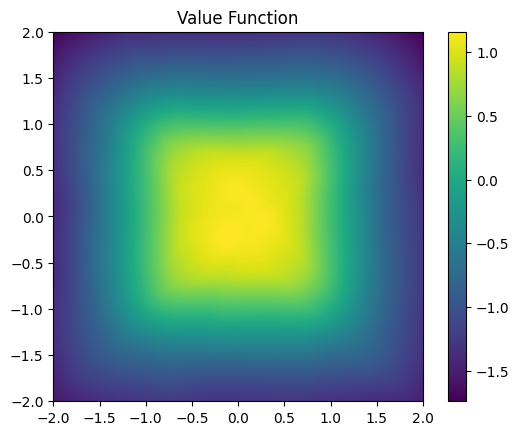

In [36]:
x = np.arange(-2, 2.01, 0.01)
y = np.arange(2, -2.01, -0.01)
xx, yy = np.meshgrid(x, y)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])
y_pred = np.squeeze(model_shared(torch.FloatTensor(grid_points))[1].detach().numpy()).reshape(401, 401)
plt.title('Value Function')
plt.imshow(y_pred, extent=[-2,2,-2,2])
plt.colorbar()